# This notebook reads in the merger tree data (tree.hdf5) and makes a few useful, smaller data files.

In [1]:
import os
import sys
import pandas as pd
pd.set_option('display.max_rows', 600)
import numpy as np
import h5py
import time
#from astropy.cosmology import FlatLambdaCDM
#from astropy.modeling.physical_models import NFW
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
# Define useful global constants.
omega_l=0.6879
omega_m=0.3121
h=0.6751
H0=0.1*h  # km / s / kpc
part_mass=1.9693723*1e-06*1e10/h
G=4.30091*1e-6 # kpc / Msolar (km/s)^2

#cosmo = FlatLambdaCDM(H0=67.51, Om0=0.3121, Tcmb0=2.725)
#t0 = cosmo.age(0).value

# Input data: file paths etc.
- If I make this notebook into a python script, then these will likely be put into a parameter text file.

In [3]:
tree_fpath = "/scratch/05097/hk9457/FIREII/m12c_r7100/halo/rockstar_dm/catalog_hdf5/tree.hdf5"


# Read in the tree file.

In [4]:
t_s = time.time()
mt_hf = h5py.File(tree_fpath, 'r')
# Keys
first_level_keys = list(mt_hf.keys())
final_idx_arr = np.unique(mt_hf['final.index'])
# Group the data by 'final.index': this groups tree data halo-by-halo.
t_e = time.time()
# Print some info.
print(f"* First level group names: {first_level_keys}")
print()
print(f"* Number of halos in the tree data: {len(final_idx_arr)}")
print()
print(f"* Time taken: {t_e - t_s:.3f} s")

* First level group names: ['am.phantom', 'am.progenitor.main', 'axis.b_div.by_a', 'axis.c_div.by_a', 'catalog.index', 'central.index', 'central.local.index', 'cosmology:baryon.fraction', 'cosmology:hubble', 'cosmology:n_s', 'cosmology:omega_baryon', 'cosmology:omega_curvature', 'cosmology:omega_dm', 'cosmology:omega_lambda', 'cosmology:omega_matter', 'cosmology:sigma_8', 'cosmology:w', 'descendant.index', 'descendant.snapshot', 'dindex', 'final.index', 'host.distance', 'host.index', 'host.velocity', 'host.velocity.rad', 'host.velocity.tan', 'info:box.length', 'info:box.length_div.by_h', 'major.merger.snapshot', 'mass', 'mass.180m', 'mass.200c', 'mass.200m', 'mass.500c', 'mass.bound', 'mass.lowres', 'mass.vir', 'position', 'position.offset', 'progenitor.co.dindex', 'progenitor.co.index', 'progenitor.last.dindex', 'progenitor.main.index', 'progenitor.main.last.dindex', 'progenitor.number', 'radius', 'scale.radius', 'scale.radius.klypin', 'snapshot', 'spin.bullock', 'spin.peebles', 'tid'

In [5]:
print(len(mt_hf['dindex']), len(np.unique(mt_hf['dindex'])), np.max(mt_hf['dindex']))
print(len(mt_hf['tid']), len(np.unique(mt_hf['tid'])), np.max(mt_hf['tid']))

48624384 48624384 48624383
48624384 48624384 64768064


# Convert the data to a Pandas dataframe.

In [6]:
t_s = time.time()
mt_dict = {}
for i in range(len(first_level_keys)):
    dict_key = first_level_keys[i]
    # Skip simulation information entries.
    if "cosmology" in dict_key:
        continue
    if "info" in dict_key:
        continue
    dict_value = mt_hf[dict_key][:]
    if dict_key == 'host.distance':
        mt_dict['host.x'] = dict_value[:,0]
        mt_dict['host.y'] = dict_value[:,1]
        mt_dict['host.z'] = dict_value[:,2]
        continue
    elif dict_key == 'host.velocity':
        mt_dict['host.vx'] = dict_value[:,0]
        mt_dict['host.vy'] = dict_value[:,1]
        mt_dict['host.vz'] = dict_value[:,2]
        continue
    elif dict_key == 'position':
        mt_dict['x'] = dict_value[:,0]
        mt_dict['y'] = dict_value[:,1]
        mt_dict['z'] = dict_value[:,2]
        continue
    elif dict_key == 'velocity':
        mt_dict['vx'] = dict_value[:,0]
        mt_dict['vy'] = dict_value[:,1]
        mt_dict['vz'] = dict_value[:,2]
        continue
    # Append to dictionary.
    mt_dict[dict_key] = dict_value
# Convert the dictionary to a Pandas dataframe
mt_df = pd.DataFrame.from_dict(mt_dict)
t_e = time.time()
print(f"* Time taken: {t_e - t_s:.3f} s")

* Time taken: 24.474 s


In [7]:
# Group the dataframe by 'final.index': halo-by-halo.
t_s = time.time()
mt_grouped_by_final_tid = mt_df.groupby(by='final.index')
t_e = time.time()
print(f"* Time taken: {t_e - t_s:.3f} s")

* Time taken: 0.001 s


# Get the main branch of all halos.

In [41]:
t_s = time.time()
main_branch_list = []
for i in range(len(final_idx_arr)):
    current_ftid = final_idx_arr[i]
    # Get the tree data for the current halo.
    current_tree = mt_grouped_by_final_tid.get_group(current_ftid)
    # Get the main branch for the current halo.
    main_progenitor_last_didx = int(current_tree.iloc[0]['progenitor.main.last.dindex'])
    main_branch = current_tree.query('`progenitor.main.last.dindex`==@main_progenitor_last_didx')
    # Check, just in case, that all elements in the main branch are actually main branch elements.
    if len(np.where(main_branch['am.progenitor.main'].values==0)[0]) > 0:
        print("*** Something wrong: non-main branch element present!")
    # Append to the final list.
    main_branch_list.append(main_branch)
    if i in [1000, 10000, 30000, 50000, 70000, 90000]:
        t_e_check = time.time()
        print(i, f"{t_e_check - t_s:.3f} s")
    tree_tid = int(main_branch['tid'].values[0])
    tree_tid_arr = np.full(len(main_branch), fill_value=tree_tid)
    # Add a tree ID array.
    main_branch.insert(0, "tree.tid", tree_tid_arr)
t_e = time.time()
print(f"* Time taken: {t_e - t_s:.3f} s")

1000 6.902 s
10000 61.515 s
30000 183.115 s
50000 304.650 s
70000 426.078 s
90000 546.312 s
* Time taken: 570.623 s


# Convert the list of main branch dataframes to one big dataframe.

In [42]:
t_s = time.time()
final_main_branch_df = pd.concat(main_branch_list)
t_e = time.time()
print(f"* Time taken: {t_e - t_s:.3f} s")
print()
print(len(np.unique(final_main_branch_df['final.index'].values)))
print(len(np.unique(final_main_branch_df['tree.tid'].values)))
print(len(final_main_branch_df))
print(final_main_branch_df.columns)

* Time taken: 58.474 s

93907
93907
37281340
Index(['tree.tid', 'am.phantom', 'am.progenitor.main', 'axis.b_div.by_a',
       'axis.c_div.by_a', 'catalog.index', 'central.index',
       'central.local.index', 'descendant.index', 'descendant.snapshot',
       'dindex', 'final.index', 'host.x', 'host.y', 'host.z', 'host.index',
       'host.vx', 'host.vy', 'host.vz', 'host.velocity.rad',
       'host.velocity.tan', 'major.merger.snapshot', 'mass', 'mass.180m',
       'mass.200c', 'mass.200m', 'mass.500c', 'mass.bound', 'mass.lowres',
       'mass.vir', 'x', 'y', 'z', 'position.offset', 'progenitor.co.dindex',
       'progenitor.co.index', 'progenitor.last.dindex',
       'progenitor.main.index', 'progenitor.main.last.dindex',
       'progenitor.number', 'radius', 'scale.radius', 'scale.radius.klypin',
       'snapshot', 'spin.bullock', 'spin.peebles', 'tid', 'vel.circ.max',
       'vel.std', 'vx', 'vy', 'vz', 'velocity.offset'],
      dtype='object')


# Save the main branch data as a .hdf5 file.

In [43]:
t_s = time.time()
main_branch_out_fname_hdf = "/scratch/05097/hk9457/FIREII/m12c_r7100/tree_processed_data/main_branches.hdf5"
final_main_branch_df.to_hdf(main_branch_out_fname_hdf, key='df', index=False)
t_e = time.time()
print("* Main branch data saved at:")
print(f"    {main_branch_out_fname_hdf}")
print()
print(f"* Time taken: {t_e - t_s:.3f} s")

* Main branch data saved at:
    /scratch/05097/hk9457/FIREII/m12c_r7100/tree_processed_data/main_branches.hdf5

* Time taken: 25.532 s


# Check the saved main branch file.

In [8]:
t_s = time.time()
main_branch_out_fname_hdf = "/scratch/05097/hk9457/FIREII/m12c_r7100/tree_processed_data/main_branches.hdf5"
saved_main_branch_file_check_df = pd.read_hdf(main_branch_out_fname_hdf)
t_e = time.time()
print(f"* Time taken: {t_e - t_s:.3f} s")

* Time taken: 36.832 s


In [9]:
saved_main_branch_file_check_df[:10]['tree.tid'].values

array([64689438, 64689438, 64689438, 64689438, 64689438, 64689438,
       64689438, 64689438, 64689438, 64689438], dtype=int32)

# Get the main branch of the host halo.

In [10]:
host_main_branch = saved_main_branch_file_check_df.query('`final.index`==0')
host_main_branch_early_to_late = host_main_branch.iloc[::-1]
#print(host_main_branch['final.index'].values[0])
#print(host_main_branch['descendant.index'].values)
#print(host_main_branch['tid'].values)

# Subtree data
- Subhalos that are merged to the main halo, i.e. destroyed subhaloes.

# Some checks to make sure I have the correct host halo.

In [11]:
for i in range(len(final_idx_arr)):
    current_ftid = final_idx_arr[i]
    # Get the tree data for the current halo.
    current_tree = mt_grouped_by_final_tid.get_group(current_ftid)
    vcirc_arr = current_tree['vel.circ.max'].values
    vcirc_180 = np.where(vcirc_arr > 180.)[0]
    if len(vcirc_180) > 0:
        print("Large!", current_ftid)

Large! 0


# Get the full merger tree data for the host halo

In [12]:
host_halo_ftid = final_idx_arr[0]
host_halo_full_tree_df = mt_grouped_by_final_tid.get_group(host_halo_ftid)
print(host_halo_ftid, len(host_halo_full_tree_df))

0 918826


In [13]:
# Getting the indices that give the unique snapshot array for the host tree.
host_unique_snapnums, host_unique_snapnum_idxs = np.unique(host_halo_full_tree_df['snapshot'].values, return_index=True)
# np.unique sorts the array, so flip them again to have them run from late to early times.
print(host_unique_snapnums[:10])
#host_unique_snapnums = np.flip(host_unique_snapnums)
#print(host_unique_snapnums[:10])
# host_unique_snapnum_idxs should give the main branch of the host halo: I verified it!
#host_unique_snapnum_idxs = np.flip(host_unique_snapnum_idxs)
# Host tree's tid values at these unique snapshot indices.
host_id_arr = host_halo_full_tree_df.iloc[host_unique_snapnum_idxs]['tid'].values

[ 5  6  7  8  9 10 11 12 13 14]


array([], dtype=float32)

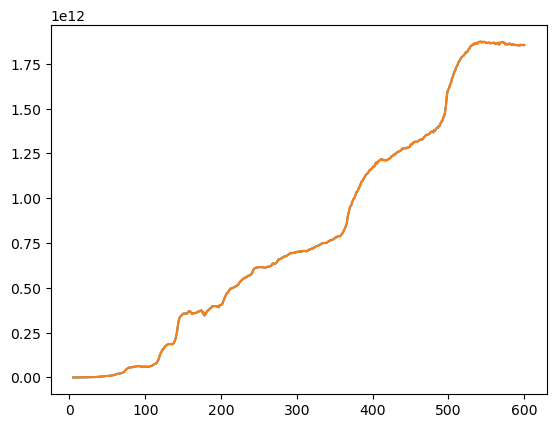

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(host_halo_full_tree_df.iloc[host_unique_snapnum_idxs]['snapshot'].values,
       host_halo_full_tree_df.iloc[host_unique_snapnum_idxs]['mass.vir'].values)
ax.plot(host_main_branch['snapshot'].values,
        host_main_branch['mass.vir'].values)
host_main_branch['mass.vir'].values[np.flip(host_main_branch['mass.vir'].values)!=host_halo_full_tree_df.iloc[host_unique_snapnum_idxs]['mass.vir'].values]

In [15]:
def host_tree_subhalos_one_snap(loop_idx, host_tree_df, uniq_time_idx):
    '''
    * A function to obtain all subhalos from the host tree at the snapshot given by the snapshot index.
      - All of these subhalos will merge to the host halo at some point.
      - So they are all disrupted subhalos.
    Returns:
    - host_tree_snap: Slice of the host tree dataframe containing all subhalos at the given snapshot.
    - first_idx: lower index used to slice the dataframe.
    --- it will be added to subhalo_idx in the function make_single_subtree.
    - last_idx: upper index used to slice the dataframe.
    '''
    # Get indices to slice the tree with.
    # If the halo is found at the first snapshot of the host tree,
    # last_idx is the last index of the series.
    if loop_idx == 0:
        # i+1 because the ith index is for the main branch.
        first_idx = uniq_time_idx[loop_idx]+1
        # The last index for the first snapshot is the last index of the host tree.
        last_idx = len(host_tree_df)
    
    # All remaining snapshots.
    else:
        # i + 1 because the ith index is for the main branch.
        first_idx = uniq_time_idx[loop_idx] + 1
        last_idx = uniq_time_idx[loop_idx-1]
       
    '''
    # Last snapshot of the simulation.
    elif snap == len(uniq_scales[0]) - 1:
        # There is no subhalo tree for the last snapshot, so break.
        return
    '''
        
    # Slice the host halo tree by the indices.
    host_tree_snap = host_tree_df[first_idx:last_idx]
    
    # Return the tree slice.
    return(host_tree_snap, first_idx, last_idx)
#
def host_tree_subhalos_one_snap_late_to_early(loop_idx, host_tree_df, unique_time_idx):
    if loop_idx == 0:
        print(f"* Error: Last snapshot!")
    '''
    # Get indices to slice the full host halo tree to obtain all elements at the snapshot corresponding to loop_idx.
    '''
    # index+1 because the ith index is for the main branch.
    first_idx = unique_time_idx[loop_idx]+1
    # last_idx itself points to the host halo at the next snapshot.
    last_idx = unique_time_idx[loop_idx+1]
    # Slice the host halo tree by the indices: all host tree elements at the current snapshot other than the main branch.
    host_tree_full_snap = host_tree_df[first_idx:last_idx]
    return(host_tree_full_snap, first_idx, last_idx)
#
def make_single_subtree(tid, snap, tree_df, uniq_scales_idx, host_id):
    '''
    * A function 
    Input:
    - tid (integer): halo's id from the merger tree at the snapshot it is found for the first time.
    - snap (integer): snapshot number the halo is found for the first time.
    - tree_df: merger tree of the host halo.
    - uniq_scales (array/list): -> Changed it to uniq_scales_idx. It's the same as uniq_scales[1]
    -- [0] unique scale factors of the host from the entire scale factor array, from early to late.
    -- [1] indices that give [0].
    - uniq_scales_idx: early to late
    - host_id: host halo's main branch tree ids.
    
    Returns:
    - idx_list: index of the host tree dataframe that will give the tree for the current subhalo (tid).
    '''
    # Empty index list: iloc locations corresponding to the current subhalo will be stored here.
    idx_list = []
    for i in range(len(uniq_scales_idx) - snap):
        i = i + snap
        
        # The last snapshot of the simulation doesn't have subhalos, so will be skipped.
        if i < len(uniq_scales_idx) - 1:
            # Get all subhalos in the current snapshot.
            snap_subhalos, first_idx, last_idx = host_tree_subhalos_one_snap(i, tree_df, uniq_scales_idx)
            
            # At the snapshot the subhalo is found for the first time:
            if i == snap:
                # Find the index of the current halo and get its desc_id.
                # Find the index of the current subhalo.
                subhalo_idx = np.where(snap_subhalos['id'] == tid)[0][0]

                # Descendant ID at the current snapshot - matches to ID at the next snapshot.
                desc_id = snap_subhalos['desc_id'].iloc[subhalo_idx]
            
                # Append the first index to the index list.
                # *** The index to return is subhalo_idx+first_idx because it will be used
                # *** with the whole host tree dataframe.
                idx_list.append(subhalo_idx+first_idx)
                
            # All remaining snapshots:
            else:
                # Find the index of the subhalo that has an ID that matches to the desc_id from the
                # previous snapshot.
                subhalo_idx = np.where(snap_subhalos['id'] == desc_id)[0]
                
                if len(subhalo_idx) > 0:
                    # There is a matching subhalo,
                    # so the descendant is not the host halo (i.e. not destroyed).
                    subhalo_idx = subhalo_idx[0]
                    desc_id = snap_subhalos['desc_id'].iloc[subhalo_idx]
                    
                    # Append the index to the index list.
                    # *** The index to return is subhalo_idx+first_idx because it will be used
                    # *** with the whole host tree dataframe.
                    idx_list.append(subhalo_idx+first_idx)
                    
                else:
                    # Subhalo merges to the host halo at the next snapshot.
                    # Check this.
                    host_id_next = np.flip(host_id)[i]
                    if host_id_next == desc_id:
                        break
                        
                    else:
                        # Print an error message.
                        print("* Error: No desc_id - id match is found but it also didn't merge to the host!")
                    
    return(idx_list)

In [25]:
# A list to add subtree dataframes to: it will be converted to one big dataframe at the end.
full_subtree_df_list = []
num_subtrees = 0
for i in range(len(host_unique_snapnums[:3])):
    current_snap = np.flip(host_unique_snapnums)[i]
    print(current_snap)
    current_snap_host_main_branch = host_main_branch.iloc[[i]]
    print(current_snap_host_main_branch[['x','y','z']].values)
    current_snap_host_index = current_snap_host_main_branch.index.values[0]
    # progenitor.main.last.dindex of all elements in host_halo_full_tree_df
    full_prog_main_last_didx_arr = host_halo_full_tree_df['progenitor.main.last.dindex'].values
    if i == 0:
        print("* Last snapshot: no merging subhalos!")
        print(f"  * Host index: {current_snap_host_index}")
        print(f"  * # host progenitors from previous snap: {current_snap_host_main_branch['progenitor.number'].values[0]}")
    elif i > 0:
        if i == (len(host_unique_snapnums)-1):
            # The last loop index: first snapshot of the host tree, so no merging subhalos!
            continue
        print(f"* Loop index: {i}, Snapshot: {current_snap}")
        print(f"  * # host progenitors from previous snap: {current_snap_host_main_branch['progenitor.number'].values[0]}")
        print(f"  * Host index: {current_snap_host_index}")
        # Get all (sub)halos in the host full tree data at the current snapshot.
        # The number of halos in 'current_snap_subs' usually will not be the same as 'progenitor.number'.
        current_snap_subs, first_idx, last_idx = host_tree_subhalos_one_snap_late_to_early(i, host_halo_full_tree_df, np.flip(host_unique_snapnum_idxs))
        print(current_snap_host_main_branch['radius'].values)
        print(current_snap_subs[['x','y','z']].values)
        print(current_snap_subs[['host.x']])
        print(current_snap_subs[['position.offset']])
        # descendant.index for current_snap_subs
        descendant_idxs = current_snap_subs['descendant.index'].values
        # Get indices (not tree indices, indices within current_snap_subs) of halos that merge to the host halo at the current snapshot.
        # Two ways to do this:
        #   1) Select those with 'descendant.index' equal to the host index at the next snapshot.
        #   2) Select thost that are NOT the main progenitor at the current snapshot: 'am.progenitor.main'==0.
        # 
        #subs_merging_now = current_snap_subs.iloc[np.where(descendant_idxs==next_snap_host_idx)[0]]
        subs_merging_now = current_snap_subs.iloc[np.where(current_snap_subs['am.progenitor.main']==0)[0]]
        num_subtrees += len(subs_merging_now)
        # Make subtrees for all subhalos that are merging now.
        for j in range(len(subs_merging_now)):
            current_sub_prog_main_last_didx = subs_merging_now.iloc[[j]]['progenitor.main.last.dindex'].values[0]
            current_sub_prog_idxs = np.where(full_prog_main_last_didx_arr == current_sub_prog_main_last_didx)[0]
            current_sub_tree = host_halo_full_tree_df.iloc[current_sub_prog_idxs]
            # Make sure the tree is correct by comparing the tree index and descendant.index.
            current_tree_desc_idxs = current_sub_tree['descendant.index'].values
            current_tree_idxs = current_sub_tree.index.values
            if len(np.where(current_tree_idxs[:-1]!=current_tree_desc_idxs[1:])[0]) != 0:
                print(f"  *** tree index and descendant.index not matching: progenitor.main.last.dindex-{current_sub_prog_main_last_didx}")
            tree_tid = current_sub_tree['tid'].values[0]
            tree_tid_arr = np.full(len(current_sub_tree), fill_value=tree_tid)
            # Add a tree ID array to the current tree.
            current_sub_tree.insert(0, 'tree.tid', tree_tid_arr)
            # Append the subtree to the result list.
            full_subtree_df_list.append(current_sub_tree)
            #
    next_snap_host_idx = current_snap_host_index
# Convert the list of dataframes to one big dataframe.
full_subtree_df = pd.concat(full_subtree_df_list)

600
[[34780.516 53336.426 45072.61 ]]
* Last snapshot: no merging subhalos!
  * Host index: 0
  * # host progenitors from previous snap: 24
599
[[34783.137 53336.188 45072.566]]
* Loop index: 1, Snapshot: 599
  * # host progenitors from previous snap: 9
  * Host index: 1
[391.10693]
[[34764.133 53347.555 45073.46 ]
 [34791.68  53337.496 45035.344]
 [34645.57  53214.86  45102.566]
 [34660.1   53144.305 44991.824]
 [34677.535 53277.45  45108.38 ]
 [34789.8   53361.812 45112.934]
 [34792.395 53351.78  45281.54 ]
 [34801.453 53246.254 45123.76 ]
 [34665.414 53304.094 44862.152]
 [34956.01  53195.355 45017.92 ]
 [34768.434 53341.47  44894.418]
 [34704.344 53479.8   45197.594]
 [34766.754 53425.63  45143.59 ]
 [34811.867 53358.605 44906.156]
 [34970.4   53301.754 45056.152]
 [34616.84  53456.61  44990.13 ]
 [34743.406 53156.473 45137.68 ]
 [35008.547 53346.992 45103.863]
 [34691.566 53252.297 45072.35 ]
 [34905.37  53185.94  45117.777]
 [34764.746 53317.723 44995.4  ]
 [34975.613 53423.12  4

In [73]:
print(f"* Number of disrupted subhalos found: {num_subtrees}")
print(f"  * {len(np.unique(full_subtree_df['tree.tid'].values))}")
print(f"* Number of rows in the full subtree dataframe: {len(full_subtree_df)}")

* Number of disrupted subhalos found: 6704
  * 6704
* Number of rows in the full subtree dataframe: 918230


# Save the subtree data as a .hdf5 file.

In [74]:
t_s = time.time()
subtree_out_fname_hdf = "/scratch/05097/hk9457/FIREII/m12c_r7100/tree_processed_data/subtree_main_branches.hdf5"
full_subtree_df.to_hdf(subtree_out_fname_hdf, key='df', index=False)
t_e = time.time()
print("* Main branch data saved at:")
print(f"    {subtree_out_fname_hdf}")
print()
print(f"* Time taken: {t_e - t_s:.3f} s")

* Main branch data saved at:
    /scratch/05097/hk9457/FIREII/m12c_r7100/tree_processed_data/subtree_main_branches.hdf5

* Time taken: 0.668 s


In [75]:
t_s = time.time()
subtree_out_fname_hdf = "/scratch/05097/hk9457/FIREII/m12c_r7100/tree_processed_data/subtree_main_branches.hdf5"
saved_subtree_file_check_df = pd.read_hdf(subtree_out_fname_hdf)
t_e = time.time()
print(f"* Time taken: {t_e - t_s:.3f} s")

* Time taken: 0.765 s


In [76]:
saved_subtree_file_check_df

,tree.tid,am.phantom,am.progenitor.main,axis.b_div.by_a,axis.c_div.by_a,catalog.index,central.index,central.local.index,descendant.index,descendant.snapshot,...,snapshot,spin.bullock,spin.peebles,tid,vel.circ.max,vel.std,vx,vy,vz,velocity.offset
2,64582638,0,0,0.892910,0.168540,25335,1,6018935,0,600,...,599,0.000190,0.00001,64582638,8.50,18.629999,-293.299988,482.119995,154.839996,584.590027
34,64582638,1,1,0.714328,0.134832,-48624385,25,6018936,2,599,...,598,0.040228,0.01287,64474937,8.56,17.290001,-295.510010,483.529999,154.990005,468.403992
79,64582638,2,1,0.535746,0.101124,-48624385,57,6018937,34,598,...,597,0.080266,0.02573,64366412,8.61,15.710000,-297.779999,484.950012,155.070007,352.217987
138,64582638,3,1,0.357164,0.067416,-48624385,102,8975232,79,597,...,596,0.120304,0.03858,64257109,8.67,13.730000,-299.859985,486.269989,155.220001,236.031998
211,64582638,4,1,0.178582,0.033708,-48624385,161,8975233,138,596,...,595,0.160342,0.05144,64147231,8.73,10.900000,-301.940002,487.529999,155.419998,119.846001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918608,20216,0,1,0.834190,0.468500,61,-48624385,-48624385,918563,14,...,13,0.072180,0.06407,12654,13.18,16.730000,-69.389999,144.940002,66.660004,3.220000
918560,14922,0,0,0.434980,0.264660,186,-48624385,-48624385,918514,15,...,14,0.053290,0.01125,14922,13.04,13.270000,-65.230003,93.589996,21.879999,5.450000
918605,14922,0,1,0.716680,0.266250,167,-48624385,-48624385,918560,14,...,13,0.058610,0.02788,12637,13.44,15.960000,-66.129997,91.699997,17.090000,7.440000
918645,14922,1,1,0.716680,0.266250,-48624385,-48624385,-48624385,918605,13,...,12,0.058610,0.02788,10586,13.44,15.960000,-66.330002,91.980003,17.139999,7.440000


In [77]:
len(saved_subtree_file_check_df)

918230

# Save the host halo main branch data as a .csv file.

In [79]:
host_main_branch_fname = "/scratch/05097/hk9457/FIREII/m12c_r7100/tree_processed_data/host_main_branch.csv"
host_main_branch.to_csv(host_main_branch_fname, index=False)